<a href="https://colab.research.google.com/github/xpdlaldam/nlp/blob/master/Hugging%20Face/audio_analysis/import_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.getcwd()

'/content'

In [3]:
os.chdir("drive/MyDrive/Colab Notebooks/Data/Audio")
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Data/Audio'

In [4]:
curr_dir_files = os.listdir()
curr_dir_files[0]

'wef_02484_00003859772.wav'

# 1. Three Ways to Read WAV Files

## Method 1: scipy.io.wavfile

In [38]:
from scipy.io import wavfile

In [39]:
sample_rate, data = wavfile.read(curr_dir_files[0])

print(f"Sample rate: {sample_rate} Hz")
print(f"Data shape: {data.shape}")

Sample rate: 48000 Hz
Data shape: (262144,)


## Method 2: librosa (best for audio analysis)

In [42]:
%pip install --upgrade numba llvmlite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0


In [5]:
import librosa

In [6]:
audio, sample_rate = librosa.load(curr_dir_files[0], sr=None)

print(f"Sample rate: {sample_rate} Hz")
print(f"Audio shape: {audio.shape}")

Sample rate: 48000 Hz
Audio shape: (262144,)


## Method 3: wave module (low-level handling)

In [ ]:
import wave
import numpy as np

with wave.open(curr_dir_files[0], "rb") as wav_file:
    sample_rate = wav_file.getframerate()
    n_frames = wav_file.getnframes()
    audio_data = wav_file.readframes(n_frames)
    audio_np = np.frombuffer(audio_data, dtype=np.int16)

print(f"Sample rate: {sample_rate} Hz")
print(f"Number of frames: {n_frames}")
print(f"Audio length: {len(audio_np)} samples")

Sample rate: 48000 Hz
Number of frames: 262144
Audio length: 262144 samples


# 2. Play Audio

## Method 1: IPython.display.Audio (best for Jupyter Notebooks)

In [ ]:
## only works in Jupyter or IPython
from IPython.display import Audio

In [ ]:
Audio(curr_dir_files[0])

## Method 2: pydub + simpleaudio (non-blocking and more control)

In [ ]:
## Doesn't work in Jupyter
from pydub import AudioSegment
from pydub.playback import play

In [ ]:
audio_0 = AudioSegment.from_wav(curr_dir_files[0])
play(audio_0)

# 3. Plot Waveform

## 3-1. W/o using gradio non-interactive

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [8]:
# Load the audio file
audio, sample_rate = librosa.load(curr_dir_files[0], sr=None) # sr=None preserves original sampling rate
audio.shape # Mono; Stereo shape is (2, num_samples)

(262144,)

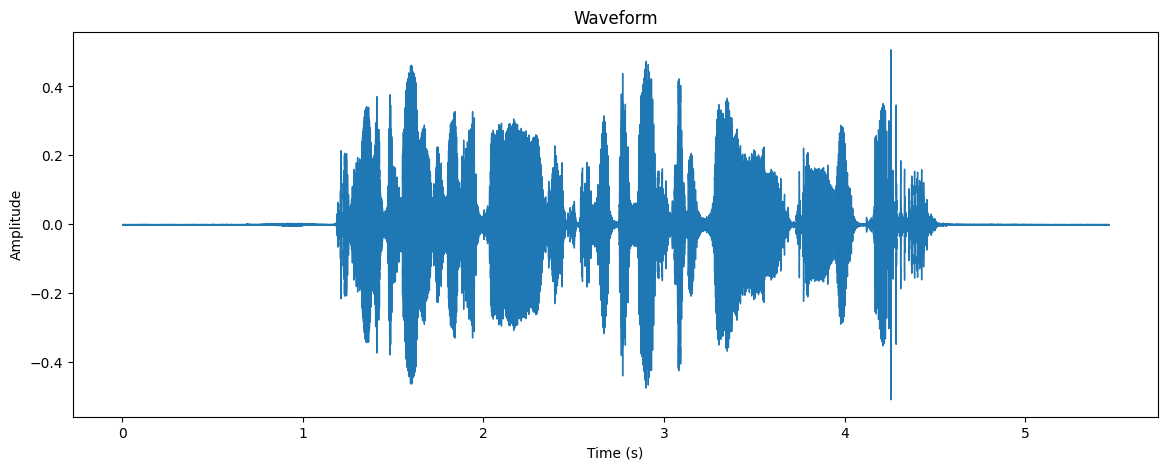

In [9]:
# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sample_rate)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## 3-2. Using gradio

# 4. Add Speech-to-text to gradio

In [5]:
%pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 51.0 MB/s eta 0:00:00


In [ ]:
%pip install openai-whisper

In [12]:
import gradio as gr
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import io
from PIL import Image
import speech_recognition as sr
import whisper

def plot_waveform(audio_file):
    try:
        # Load audio
        audio, sr = librosa.load(audio_file, sr=None)
        if len(audio) == 0:
            raise ValueError("Audio file is empty or unreadable.")

        # Time axis in seconds
        time = np.linspace(0, len(audio)/sr, num=len(audio))

        # Create plot
        fig, ax = plt.subplots(figsize=(10, 3))
        ax.plot(time, audio, color='blue')
        ax.set_title("Waveform")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        fig.tight_layout()

        # Save to buffer
        buf = io.BytesIO()
        fig.savefig(buf, format="png")
        plt.close(fig)
        buf.seek(0)

        # Convert to numpy array image instead of PIL.Image (more stable for Gradio)
        image = Image.open(buf).convert("RGB")
        return np.array(image)

    except Exception as e:
        return f"Waveform error: {e}"


# def plot_waveform(audio_file):
#     try:
#         ## Load audio
#         audio, sample_rate = librosa.load(audio_file, sr=None)

#         if len(audio) == 0:
#             raise ValueError("Audio file is empty or unreadable.")

#         ## Plot waveform
#         plt.figure(figsize=(10, 3))
#         librosa.display.waveshow(audio, sr=sample_rate, alpha=0.7)
#         plt.title('Waveform')
#         plt.xlabel('Time (s)')
#         plt.ylabel('Amplitude')
#         plt.tight_layout()  # Ensure nothing gets cut off

#         ## Save plot to buffer (a temporary storage in memory that holds data -- in this case, binary data representing the PNG image of the waveform plot)
#         # creates an in-memory binary buffer stored in RAM instead of on disk
#         # useful when working with file-like data (images, audio, etc.) without actually writing to the filesystem
#         buf = io.BytesIO()
#         plt.savefig(buf, format='png', bbox_inches='tight') # Ensure full plot is saved

#         plt.close()
#         buf.seek(0) # Resets the "cursor" of the buffer to the beginning so it can be read properly
#         img = Image.open(buf) # Opens the image from memory as if it were a file

#         return img

#     except Exception as e:
#         return f"Waveform error: {e}"


def speech_to_text_google(audio_file):
    if audio_file is None:
        return "No audio file provided."

    r = sr.Recognizer()
    with sr.AudioFile(audio_file) as source:
        audio_data = r.record(source)
    try:
        text = r.recognize_google(audio_data)
        return text
    except sr.UnknownValueError:
        return "Could not understand audio"
    except sr.RequestError as e:
        return f"Could not request results; {e}"


# Load model once (globally for speed)
whisper_model = whisper.load_model("base") # options: tiny, base, small, medium, large
def speech_to_text_whisper(audio_file):
    try:
        result = whisper_model.transcribe(audio_file)
        return result['text']
    except Exception as e:
        return f"Whisper transcription error: {e}"


def process_audio(audio_file, speech_to_text_model):
    try:
        waveform = plot_waveform(audio_file)
    except Exception as e:
        waveform = f"Waveform error: {e}"

    try:
        if speech_to_text_model == "google":
            transcription = speech_to_text_google(audio_file)
        elif speech_to_text_model == "whisper":
          transcription = speech_to_text_whisper(audio_file)
    except Exception as e:
        transcription = f"Transcription error: {e}"

    return waveform, transcription


with gr.Blocks() as demo:
    gr.Markdown("# 🎵 Audio Waveform Viewer & Speech-to-Text")

    with gr.Row():
        audio_input = gr.Audio(type="filepath", label="Upload your .wav file")

    with gr.Row():
        model_selector = gr.Dropdown(
            choices=["google", "whisper"],
            value="whisper",
            label="Choose Speech-to-Text Model"
        )

    with gr.Row():
        waveform_output = gr.Image(type="numpy", label="Waveform")
        transcript_output = gr.Textbox(label="Transcription")

    audio_input.upload(
            fn=process_audio,
            inputs=[audio_input, model_selector],
            outputs=[waveform_output, transcript_output],
        )

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8b21c8e0af5aa6582d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 5. Spectogram

In [1]:
"""
- Frequency
  - number of complete cycles (waves or vibration of vocal folds) in a second (unit: Hz)
  -
  - acoustic phonetics

- Pitch
  - similar to frequency but more like how humans hear sound
  - auditory phonetics

- Intensity/Loudness vs Amplitude
  - intensity or power, acoustic feature
  - corresponds to loudness/volume (unit: db), auditory phonetic feature
  - subjective perception of speech sounds

  - Amplitude
    - the extent to which an air particle moves to and from its reset point in a sound wave
    - higher amplitude means higher intensity
    - a physical property of speech sounds

  - Fundamental Frequency
    - the lowest frequency component in a complex sound wave
    - aka F0 or first harmonic


- Spectogram
  - A 3D visual representation of speech
  - x-axis: time
  - y-axis: frequency
  - color: amplitude or intensity by blackness

- Tambre: shows the quality of sound
"""

'\n- Frequency: number of complete cycles (waves or vibration of vocal folds) in a second (unit: Hz)\n\n- Spectogram\n  - A 3D visual representation of speech \n  - x-axis: time\n  - y-axis: frequency\n  - color: amplitude or intensity by blackness\n\n- Tambre: shows the quality of sound\n'

Sample rate: 48000 Hz
Audio shape: (262144,)


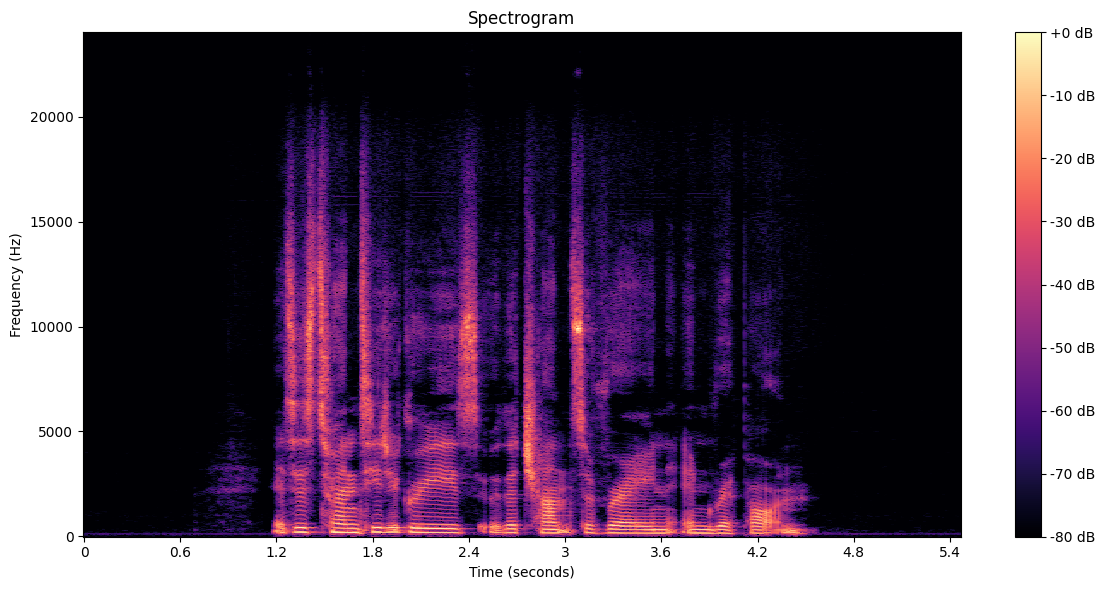

In [13]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio (you already have this)
audio, sample_rate = librosa.load(curr_dir_files[0], sr=None)

print(f"Sample rate: {sample_rate} Hz")
print(f"Audio shape: {audio.shape}")

# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(audio)

# Convert amplitude to decibels
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=sample_rate, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()
